In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def crps_fair(forecast: xr.DataArray, obs: xr.DataArray, member_dim="member"):
    """
    forecast: DataArray with a member dimension (…, member)
    obs     : DataArray broadcastable to forecast without the member dim (…)
    returns : CRPS_fair with the member dim removed
    """
    M = forecast.sizes[member_dim]
    # term1 = mean |X - y|
    term1 = (np.abs(forecast - obs)).mean(dim=member_dim)

    # term2 = 0.5 * mean_{i≠j} |X - X'|
    def _pairwise_mean_offdiag(a):
        # a: (..., M)
        # pairwise |a_i - a_j|
        diff = np.abs(a[..., None] - a[..., None, :])  # (..., M, M)
        # sum over i,j; diagonal is zero so no need to subtract explicitly
        s = diff.sum(axis=(-2, -1))
        denom = M * (M - 1)
        # handle M=1 safely
        return np.where(denom > 0, 0.5 * s / denom, 0.0)

    term2 = xr.apply_ufunc(
        _pairwise_mean_offdiag, forecast,
        input_core_dims=[[member_dim]],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[forecast.dtype],
        dask_gufunc_kwargs = {'allow_rechunk':True}
    )

    return term1 - term2

In [2]:
def crps_above_threshold(F: xr.DataArray, O: xr.DataArray, thresholds, member_dim="member"):
    """
    F: forecast DA with dim (..., member, lat, lon) or (..., member, y, x)
    O: obs DA broadcastable to F without the member dim
    thresholds: float or sequence of floats (same units as O)
    returns: DataArray with dims (threshold, time, lat, lon) of CRPS_fair masked to obs>τ
    """
    if np.isscalar(thresholds):
        thresholds = [thresholds]

    out = []
    for tau in thresholds:
        mask = O > tau
        Ft = F.where(mask)
        Ot = O.where(mask)
        crps_tau = crps_fair(Ft, Ot, member_dim=member_dim)
        crps_tau = crps_tau.assign_coords(threshold=tau).expand_dims("threshold")
        out.append(crps_tau)
    return xr.concat(out, dim="threshold")

In [3]:
# ds = xr.open_zarr("AIFS_IFS_OBS_GERMANY.zarr", consolidated=True)
ds = xr.open_dataset('AIFS_IFS_OBS_GERMANY.nc')

# ds = xr.open_dataset('ERA_NH.nc')
# ds1 = xr.open_dataset('AIFS_TP_FFX24_NH.nc')

In [4]:
aifs = ds["aifs"]
ifs = ds["ifs"]
obs = ds['obs']

# obs = ds.tp_daily_06UTC
# aifs = ds.tp

In [5]:
# from dask.diagnostics import ProgressBar
# with ProgressBar():
crps_aifs = crps_fair(forecast=aifs, obs=obs, member_dim='number')
crps_ifs = crps_fair(forecast=ifs, obs=obs, member_dim='number')

In [6]:
crps_aifs.mean(), crps_ifs.mean()

(<xarray.DataArray ()> Size: 4B
 array(0.86085004, dtype=float32)
 Coordinates:
     step     timedelta64[ns] 8B 1 days
     surface  float64 8B 0.0,
 <xarray.DataArray ()> Size: 4B
 array(1.1459907, dtype=float32)
 Coordinates:
     step     timedelta64[ns] 8B 1 days
     surface  float64 8B 0.0)

In [9]:
thresholds=[0,1,5,10,15,20,25,30,35,40,45,50]

crps_aifs_ge_th, crps_ifs_ge_th = [], []
crps_aifs_ge_th_std, crps_ifs_ge_th_std = [], []
obs_count_ge = []

for threshold in thresholds[:]: 
    print(threshold)
    obs_count_ge.append((obs>threshold).sum().values.item())

    crps_aifs_ge_th.append(crps_aifs.where(obs>threshold).mean().values.item())
    crps_ifs_ge_th.append(crps_ifs.where(obs>threshold).mean().values.item())
    crps_aifs_ge_th_std.append(crps_aifs.where(obs>threshold).std().values.item())
    crps_ifs_ge_th_std.append(crps_ifs.where(obs>threshold).std().values.item())

# crps_aifs_th = crps_above_threshold(F=aifs, O=obs, member_dim='number', thresholds=thresholds)
# crps_ifs_th = crps_above_threshold(F=ifs, O=obs, member_dim='number', thresholds=thresholds)

0
1
5
10
15
20
25
30
35
40
45


/scratch2/mg963/conda_envs/envs/regrid/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch2/mg963/conda_envs/envs/regrid/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


50


/scratch2/mg963/conda_envs/envs/regrid/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch2/mg963/conda_envs/envs/regrid/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


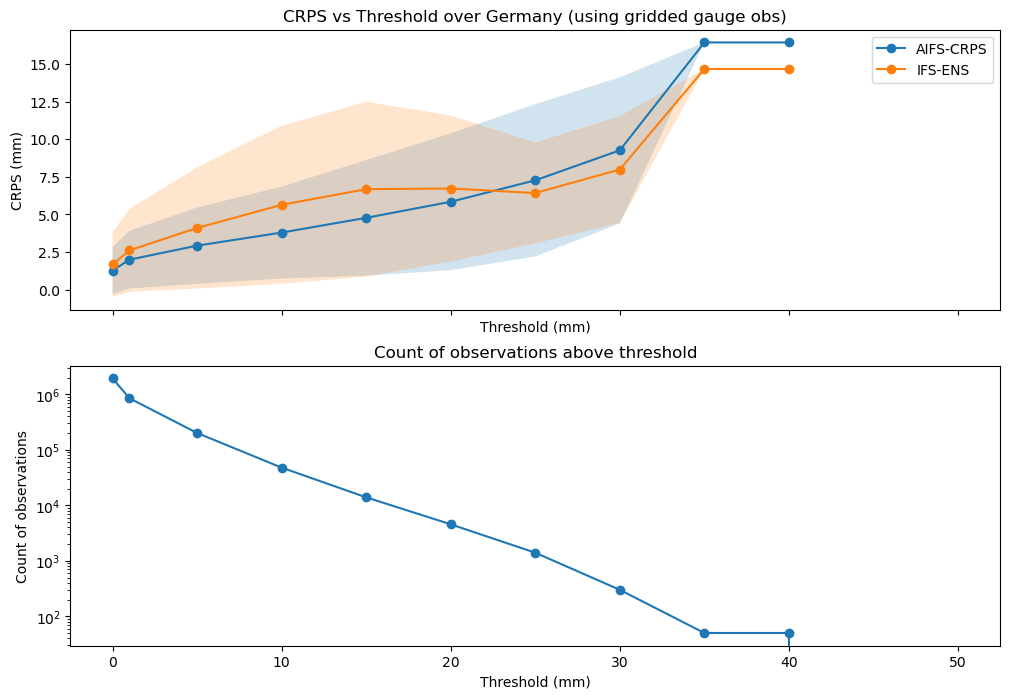

In [10]:
fig, axes = plt.subplots(2,1,figsize=(12,8), sharex=True)

ax = axes[0]
ax.plot(thresholds, crps_aifs_ge_th,  'o-',label='AIFS-CRPS')
ax.fill_between(thresholds, np.array(crps_aifs_ge_th) - np.array(crps_aifs_ge_th_std), np.array(crps_aifs_ge_th) + np.array(crps_aifs_ge_th_std), alpha=0.2)
ax.plot(thresholds, crps_ifs_ge_th, 'o-',label='IFS-ENS')
ax.fill_between(thresholds, np.array(crps_ifs_ge_th) - np.array(crps_ifs_ge_th_std), np.array(crps_ifs_ge_th) + np.array(crps_ifs_ge_th_std), alpha=0.2)

ax.set_xlabel('Threshold (mm)')
ax.set_ylabel('CRPS (mm)')
ax.legend()
ax.set_title('CRPS vs Threshold over Germany (using gridded gauge obs)')


ax = axes[1]
ax.plot(thresholds, obs_count_ge, 'o-')
ax.set_title('Count of observations above threshold')
ax.set_yscale('log')
ax.set_xlabel('Threshold (mm)')
ax.set_ylabel('Count of observations')

plt.show()

In [118]:
obs.size

6682500

In [119]:
for th in thresholds:
    x = (obs>th).sum().item()
    print(th, x, x/obs.size*100)

0 1938015 29.0013468013468
1 852140 12.75181444070333
5 201500 3.0153385708941265
10 47850 0.7160493827160495
15 13950 0.20875420875420878
20 4550 0.06808829031051254
25 1400 0.020950243172465393
30 300 0.0044893378226711555
35 50 0.0007482229704451926
40 50 0.0007482229704451926
45 0 0.0
50 0 0.0


In [109]:
# crps_aifs_th.sel(threshold=20).mean(dim=('lat','lon')).plot()

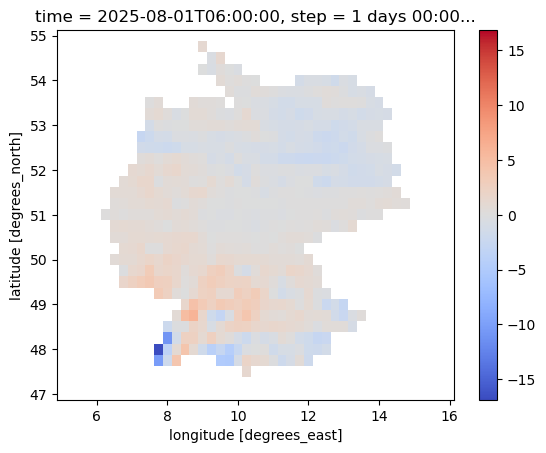

In [10]:
timestamp = 30

(crps_aifs.isel(time=timestamp) - crps_ifs.isel(time=timestamp)).plot(cmap='coolwarm');

In [31]:
df = (obs > 20).sum(dim=('lat','lon')).isel(number=0).to_pandas()